In [1]:
from tqdm import tqdm
from jax.example_libraries.optimizers import adam
from jax import value_and_grad
from collections import namedtuple
import os
os.environ["CUDA_VISIBLE_DEVICES"] ='1'
import numpy as np
import matplotlib.pyplot as plt 
import jax
import jax.numpy as jnp
from jaxpm.growth import (dGf2a, dGfa, growth_factor, growth_factor_second,
                          growth_rate, growth_rate_second, dGfa, Gf)
from jax import tree
from jax import tree
from jaxpm.pm import pm_forces
from diffrax import ConstantStepSize,  SaveAt, diffeqsolve,StepTo
from jaxpm.plotting import plot_fields_single_projection
from jaxpm.painting import cic_paint , cic_paint_dx
import diffrax
#jax.config.update("jax_enable_x64", True)
import jax
jax.print_environment_info()
from SuperResPM.configure import Configuration
from SuperResPM.diffrax_helper import FPMODE,FPMLeapFrog,symplectic_ode
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('jpeg')
import jax_cosmo as jc
from diffrax import ConstantStepSize
from jaxpm.pm import linear_field, lpt
from jaxpm.growth import (dGf2a, dGfa, growth_factor, growth_factor_second,
                          growth_rate, growth_rate_second)
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader
%matplotlib inline 


jax:    0.5.2
jaxlib: 0.5.1
numpy:  1.26.4
python: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
device info: Tesla V100-PCIE-16GB-1, 1 local devices"
process_count: 1
platform: uname_result(system='Linux', node='midway3-0297.rcc.local', release='4.18.0-305.3.1.el8.x86_64', version='#1 SMP Tue Jun 1 16:14:33 UTC 2021', machine='x86_64')


$ nvidia-smi
Tue Apr 22 13:33:43 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|========================================

/project/chto/chto/anaconda/newenv4/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
jc.__path__

['/project/chto/chto/anaconda/newenv4/lib/python3.10/site-packages/jax_cosmo']

In [3]:
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
jax.config.update("jax_enable_x64", False)

In [4]:

def full_field_model_pm_test(
    cube_size,
    cubegrid_size,
    a_init,
    a_center,
    adjoint
):
    @jax.jit
    def forward_model(cosmoin, lin_field):

        def paint_density(t, y, args):
            # Load positions and apply boundary conditions
            pos = y[0]
            x = pos[..., 1]
            y = pos[..., 2]
            z = pos[..., 0]

            # Paint all the particles that fall into slice
            ss=args[3].mesh_shape
            density = cic_paint(jnp.zeros(ss),jnp.c_[x, y, z])

            return density
            
        particles = jnp.stack(
            jnp.meshgrid(
                *[jnp.arange(s) for s in [cubegrid_size, cubegrid_size, cubegrid_size]]
            ),
            axis=-1)
        conf = Configuration(mesh_shape=[cubegrid_size, cubegrid_size, cubegrid_size],
                     snapshots= [1],
                     BoxSize=cube_size, 
                     initial_t0=a_init,
                     final_time = 1.0,
                     density_plane_npix = 10,
                     dt0=0.03)

        
        eps, p, f = lpt(cosmoin, lin_field, particles, a=conf.initial_t0)
        
        term = tree.map(
            FPMODE,
            symplectic_ode(conf.mesh_shape, paint_absolute_pos=True)
        )
        initforce = pm_forces(
            particles + eps,
            mesh_shape=conf.mesh_shape,
            paint_absolute_pos=True,
        )* 1.5* cosmoin.Omega_m  

        solver = FPMLeapFrog(initial_t0=conf.initial_t0, final_t1=conf.final_time)
        saveat = SaveAt(ts=a_center[::-1], fn=paint_density)
        stepsize_controller = ConstantStepSize()
        solution = diffeqsolve(
            term,
            solver,
            t0=conf.initial_t0,
            t1=conf.final_time,
            dt0=conf.dt0,
            y0=jnp.stack([particles + eps, p, initforce], axis=0),
            args=[cosmoin, None, conf.initial_t0, conf, 0, 0],\
            saveat=saveat,
            adjoint=adjoint,
            stepsize_controller=stepsize_controller,
        )
        
        args=[cosmoin, None, conf.initial_t0, conf, 0, 0]
        #density = paint_density(0, solution.ys[-1], args)
        ##print(solution.ys)
        #return density
        return solution.ys[-1]
    return forward_model
#####################################################################################################################


In [5]:

#if __name__ == "__main__":
key_number = 1
# Set output directory
dir_out = "./"
#Path(dir_out).mkdir(parents=True, exist_ok=True)
# Sim configuration
cube_size = 128.0  # Mpc/h
cubegrid_size = 32#128  # npix
a_init = 0.05
# Initialize the density model
dens_model_Recursive= full_field_model_pm_test(
    cube_size=cube_size,
    cubegrid_size=cubegrid_size,
    a_init = a_init,
    a_center=[0.96], 
    adjoint=diffrax.RecursiveCheckpointAdjoint()
)
dens_model_Reversible= full_field_model_pm_test(
    cube_size=cube_size,
    cubegrid_size=cubegrid_size,
    a_init = a_init,
    a_center=[0.96], 
    adjoint=diffrax.ReversibleAdjoint()#diffrax.RecursiveCheckpointAdjoint()#
)


In [6]:
def buildmodel(dens_model):
    @jax.jit
    def model(param):
        Omega_c, sigma8= param
        model_cosmo = jc.Cosmology(
            Omega_c=Omega_c,
            sigma8=sigma8,
            Omega_b=0.0492,
            Omega_k=0.0,
            h=0.67,
            n_s=0.96,
            w0=-1,
            wa=0.0,
        )
        Workspace = namedtuple('_workspace', ['background_radial_comoving_distance', 'background_growth_factor'])
        model_cosmo._workspace =Workspace(None, None)
        ain=np.atleast_1d(1)
        _ =  growth_rate_second(model_cosmo,ain)
        _ = growth_rate(model_cosmo, ain)
        _ = growth_factor(model_cosmo, ain)
        jc.background.radial_comoving_distance(model_cosmo, ain)
        k = jnp.logspace(-4, 1, 128)
        pk = jc.power.linear_matter_power(model_cosmo, k)
        pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)
        lin_field = linear_field(
            [cubegrid_size, cubegrid_size, cubegrid_size],
            [cube_size, cube_size, cube_size],
            pk_fn, jax.random.PRNGKey(0))
        dens = dens_model(model_cosmo, lin_field)
        return dens
    return model    


In [7]:
densobs = buildmodel(dens_model=dens_model_Recursive)(jnp.array([0.3,0.8]))


/project/chto/chto/anaconda/newenv4/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [8]:
model_Reversible = buildmodel(dens_model=dens_model_Reversible)
model_Recursive = buildmodel(dens_model=dens_model_Recursive)

In [9]:
@jax.jit
def lnlikelihood_Reversible(param):
    din = model_Reversible(param)
    return jnp.sum(-0.5*(densobs-din)**2)
@jax.jit
def lnlikelihood_Recursive(param):
    din = model_Recursive(param)
    return jnp.sum(-0.5*(densobs-din)**2)

In [10]:
dL_Reversible = jax.jit(jax.value_and_grad(lnlikelihood_Reversible))
dL_Recursive = jax.jit(jax.value_and_grad(lnlikelihood_Recursive))

In [11]:
cosmology_omegam = np.random.normal(size=10)*0.02+0.2

In [12]:
cosmology_sigma8 = np.random.normal(size=10)*0.1+0.8300042969349488

In [13]:
omegam, sigma8=0.3,0.8

In [14]:
%prun dL_Reversible(jnp.array([omegam, sigma8]))#, model_Reversible)[1]

         25535783 function calls (25225625 primitive calls) in 60.061 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   36.783   36.783   36.803   36.803 compiler.py:297(backend_compile)
        8    1.379    0.172    1.379    0.172 {built-in method gc.collect}
        1    1.216    1.216    1.216    1.216 pxla.py:2649(_get_layouts_from_executable)
3717058/3716840    0.617    0.000    0.647    0.000 {built-in method builtins.isinstance}
415210/407538    0.458    0.000    3.912    0.000 {jaxlib.utils.safe_map}
    997/1    0.436    0.000    5.377    5.377 mlir.py:1876(jaxpr_subcomp)
192696/192674    0.406    0.000    0.754    0.000 util.py:298(wrapper)
   137657    0.402    0.000    0.551    0.000 partial_eval.py:1809(<lambda>)
   143788    0.391    0.000    1.905    0.000 core.py:1821(get_sharding)
33431/33419    0.387    0.000    4.333    0.000 partial_eval.py:1925(default_process_primitive)
    95906    0.291   

In [15]:
%prun dL_Recursive(jnp.array([omegam, sigma8]))#, model_Reversible)[1]

         30053122 function calls (29704501 primitive calls) in 60.740 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   35.327   35.327   35.356   35.356 compiler.py:297(backend_compile)
        1    1.379    1.379    1.379    1.379 pxla.py:2649(_get_layouts_from_executable)
   183464    0.746    0.000    0.862    0.000 core.py:1702(canonicalize_shape)
4319428/4319142    0.711    0.000    0.734    0.000 {built-in method builtins.isinstance}
        2    0.637    0.318    0.637    0.318 {built-in method gc.collect}
484998/463224    0.538    0.000    6.095    0.000 {jaxlib.utils.safe_map}
233711/233675    0.483    0.000    0.893    0.000 util.py:298(wrapper)
    55505    0.480    0.000    0.487    0.000 partial_eval.py:521(__init__)
   175041    0.453    0.000    2.084    0.000 core.py:1821(get_sharding)
   1139/1    0.424    0.000    5.239    5.239 mlir.py:1876(jaxpr_subcomp)
    55925    0.407    0.000    0.481   

In [16]:
derivative=[]
for omegam, sigma8 in tqdm(zip(cosmology_omegam, cosmology_sigma8)):
    d1 = dL_Recursive(jnp.array([omegam, sigma8]))
    d2 = dL_Reversible(jnp.array([omegam, sigma8]))
    derivative.append([d1[1],d2[1]])
    print(d1,d2)

1it [00:02,  2.76s/it]

(Array(-2897.717, dtype=float32), Array([58286.465, 15298.846], dtype=float32)) (Array(-2897.6992, dtype=float32), Array([58286.176, 15298.974], dtype=float32))


2it [00:05,  2.72s/it]

(Array(-9681.041, dtype=float32), Array([ 23587.08, 185785.78], dtype=float32)) (Array(-9681.036, dtype=float32), Array([ 23587.266, 185785.69 ], dtype=float32))


3it [00:08,  2.72s/it]

(Array(-1651.1108, dtype=float32), Array([31827.664, 31106.604], dtype=float32)) (Array(-1651.1067, dtype=float32), Array([31827.602, 31106.527], dtype=float32))


4it [00:10,  2.71s/it]

(Array(-37161.164, dtype=float32), Array([ 146894.06, -244693.02], dtype=float32)) (Array(-37161.164, dtype=float32), Array([ 146893.47, -244692.97], dtype=float32))


5it [00:13,  2.71s/it]

(Array(-3800.376, dtype=float32), Array([ 81927.96 , -45328.973], dtype=float32)) (Array(-3800.3828, dtype=float32), Array([ 81927.94 , -45329.027], dtype=float32))


6it [00:16,  2.70s/it]

(Array(-35601.78, dtype=float32), Array([ 136400.05, -238976.72], dtype=float32)) (Array(-35601.742, dtype=float32), Array([ 136400.  , -238976.64], dtype=float32))


7it [00:18,  2.70s/it]

(Array(-11009.652, dtype=float32), Array([ 17374.264, 207282.38 ], dtype=float32)) (Array(-11009.65, dtype=float32), Array([ 17374.541, 207282.3  ], dtype=float32))


8it [00:21,  2.69s/it]

(Array(-7408.488, dtype=float32), Array([  75322.11, -144036.95], dtype=float32)) (Array(-7408.478, dtype=float32), Array([  75322.125, -144036.88 ], dtype=float32))


9it [00:24,  2.69s/it]

(Array(-3746.211, dtype=float32), Array([ 79298.54 , -18816.057], dtype=float32)) (Array(-3746.1958, dtype=float32), Array([ 79298.43 , -18816.088], dtype=float32))


10it [00:26,  2.70s/it]

(Array(-9061.391, dtype=float32), Array([ 22222.176, 178866.66 ], dtype=float32)) (Array(-9061.393, dtype=float32), Array([ 22222.557, 178866.72 ], dtype=float32))


In [17]:
derivative = np.array(derivative)

In [18]:
derivative.shape

(10, 2, 2)

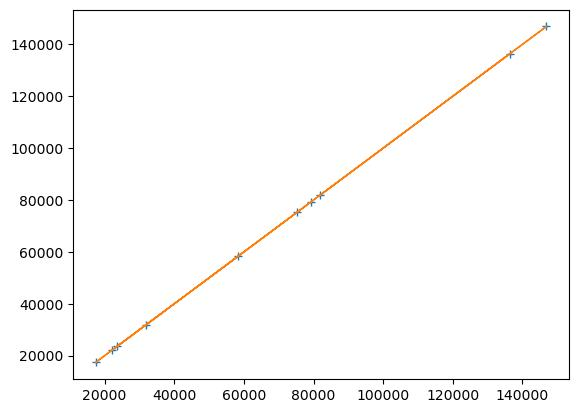

In [19]:
plt.plot(derivative[:,0,0],derivative[:,1,0], "+")
plt.plot(derivative[:,0,0],derivative[:,0,0], lw=1)




Text(0, 0.5, 'Derivative error (%)')

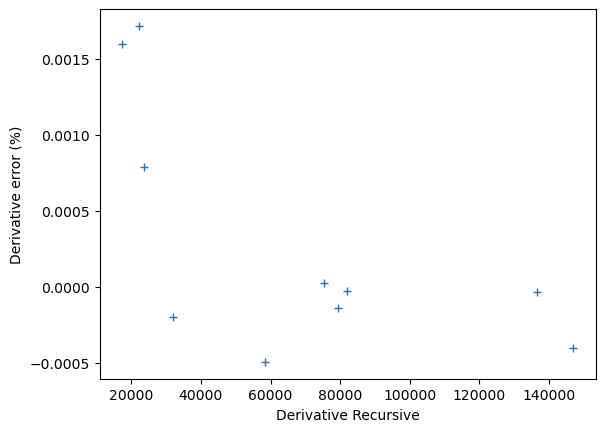

In [23]:
plt.plot(derivative[:,0,0], (derivative[:,1,0]/derivative[:,0,0]-1)*100, "+")
plt.xlabel("Derivative Recursive")
plt.ylabel("Derivative error (%)")




In [22]:
with jax.profiler.trace("tensorborard/"):
     dL_Reversible(jnp.array([omegam, sigma8]))#, model_Reversible)[1]

2025-04-21 11:11:40.442304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745251900.845194 2767057 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745251900.920901 2767057 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745251902.109694 2767057 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745251902.109737 2767057 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745251902.109739 2767057 computation_placer.cc:177] computation placer alr

In [23]:
with jax.profiler.trace("tensorborard/"):
     dL_Recursive(jnp.array([omegam, sigma8]))#, model_Reversible)[1]